In [1]:
import struct
import numpy as np
import os
import re

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

In [3]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
def interpolate_grid(x, y, z, u, new_dx):

    interp = RegularGridInterpolator((x, y, z), u) # method = "linear"
    xg,yg,zg=np.meshgrid(x,y,z,indexing='ij')
    new_shape = (int((xg[-1, 0, 0] - xg[0, 0, 0]) / new_dx) + 1,
                 int((yg[0, -1, 0] - yg[0, 0, 0]) / new_dx) + 1,
                 int((zg[0, 0, -1] - zg[0, 0, 0]) / new_dx) + 1)

    new_x, new_y, new_z = np.meshgrid(np.linspace(xg[0, 0, 0], xg[-1, 0, 0], new_shape[0]),
                                       np.linspace(yg[0, 0, 0], yg[0, -1, 0], new_shape[1]),
                                       np.linspace(zg[0, 0, 0], zg[0, 0, -1], new_shape[2]), indexing='ij')

    data2=interp((new_x,new_y,new_z))
    return new_x, new_y, new_z, data2


In [4]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
from src import OpenFile

In [14]:
#入力データのディレクトリ
data_path=r"D:\1_Simulation\2_Output\TPFITV1728_Nakagawa\orifice_case39g02\inside_avs"
# 現在のカレントディレクトリを取得します
directory_path = os.getcwd()
directory_path
output_path=r"D:\1_Simulation\3_Analysis\2024-07-06"

In [15]:
output_folder_path=OpenFile.make_folder("isosurface",output_path)
print("output_path:", output_folder_path)

Error: Directory 'D:\1_Simulation\3_Analysis\2024-07-06' does not exist.
output_path: None


In [16]:
# ファイル名を格納するリストを作成します
file_names = []

In [17]:
common_prefix,items=OpenFile.get_shared_name(data_path)
common_prefix

'inside_orifice_case39g02'

In [18]:
#座標データ抽出
points = []
for d in ["X","Y","Z"]:

    data_path_ndim=f"{data_path}/{common_prefix}{d}_00000"
    #ファイル読み込み
    with open(data_path_ndim, 'rb') as file:
        # バイナリデータを読み取り
        binary_data_ndim = file.read()
  
    # バイナリデータを文字列に変換（適切なエンコーディングを指定）
    text_data = binary_data_ndim.decode('utf-8')  # 例としてUTF-8を使用

    # 正規表現を使って「X-Axis Coordinate」に関連するデータを抽出
    pattern_d= re.compile(r'{}-Axis Coordinate\n([\s\S]*?)(?=\n[A-Z]|$)'.format(d))
    match_d = pattern_d.search(text_data)
    if match_d:
        coordinates = match_d.group(1).strip().split()
        # 数値を浮動小数点数に変換
        coordinates = np.array([float(coord) for coord in coordinates] )
        points.append(coordinates)

In [19]:
x_crop=points[0][[0,-1]]
y_crop=points[1][[0,-1]]
z_crop=points[2][[0,-1]]
x_crop,y_crop,z_crop

(array([-0.001525,  0.001525]),
 array([-0.001525,  0.001525]),
 array([-5.0000e-05,  2.0025e-02]))

In [20]:
t_avs=150
data_shape=(points[0].shape[0],points[1].shape[0],points[2].shape[0])
F_path=os.path.join(data_path,f"{common_prefix}F_{t_avs:05d}")
data_F_origin = np.array(OpenFile.get_data_from_binary(F_path)).reshape(data_shape,order="F")
# data_F=np.where(data_F>0.5,1.0,0.0)
data_F_origin.shape

(62, 62, 287)

In [21]:
# 格子幅そろえる処理
delta=0.1*10**-3
X,Y,Z, data_F=interpolate_grid(list(points[0]),list(points[1]),list(points[2]),data_F_origin,delta)
data_shape_after=data_F.shape
data_shape_after

(31, 31, 201)

In [22]:

x=X.flatten()
y=Y.flatten()
z=Z.flatten()


inc_del=np.concatenate(
    [
        np.where( (x==x_crop[0]) | (x==x_crop[1] ) ),
        np.where( (y==y_crop[0]) | (y==z_crop[1] ) ),
        np.where( (z==z_crop[0]) | (z==z_crop[1] ) )
    ],
    1
    ).flatten()

inc_del=np.unique(inc_del)
inc_del


array([     0,      1,      2, ..., 193158, 193159, 193160])

In [23]:
data_f = data_F.flatten()
data_f

# 不要要素削除
x[inc_del]=np.nan
y[inc_del]=np.nan
z[inc_del]=np.nan
data_f[inc_del]=np.nan

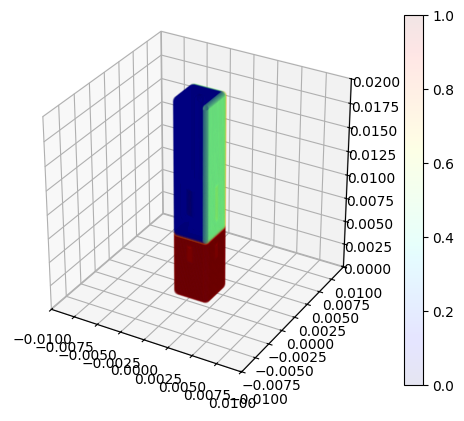

In [24]:
# https://teratail.com/questions/95095

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize # Normalizeをimport


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
sc = ax.scatter(X, Y, Z, c=data_F,vmin=0,vmax=1 , alpha=0.1, cmap='jet')
# mappable0 = ax.pcolormesh(X,Y,Z, cmap='coolwarm', norm=Normalize(vmin=0, vmax=0.6)) # ここがポイント！
fig.colorbar(sc,ax=ax)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()



In [25]:
# 座標、体積率
x, y, z, data_f.shape

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 (193161,))

In [26]:
data_f

array([nan, nan, nan, ..., nan, nan, nan])

In [27]:
# 等値面を抽出
print(data_F.shape)
inside_data_F=data_F[1:-1,1:-1,1:-1]
verts, faces, normals, values = measure.marching_cubes(inside_data_F, 0.5,spacing=(delta,delta,delta))
verts.shape,faces.shape

(31, 31, 201)


((14701, 3), (28878, 3))

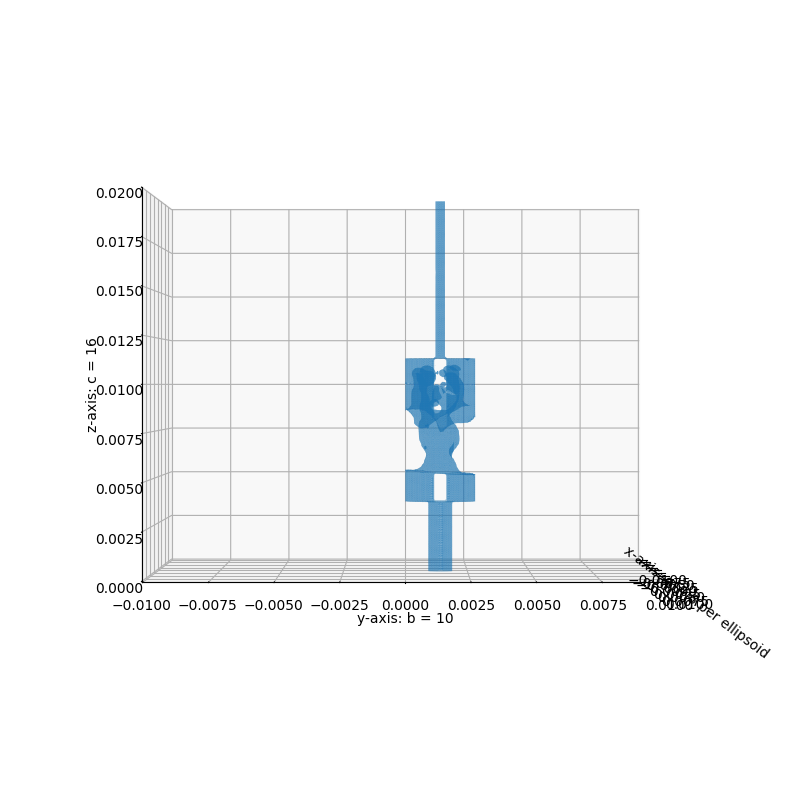

In [28]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces],alpha=0.5)
# mesh.set_edgecolor('')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev=0, azim=0)  # elevは仰角（上下の角度）、azimは方位角（左右の角度）
# plt.tight_layout()
plt.show()

## 閉塞領域の算出

In [37]:
from scipy.ndimage import label
import numpy as np
def extract_closed_regions(data,thredhold=0.5):
    # 0.5以下の値を抜き取る
    # print(np.where(data.astype(float)<0.5)) 
    labeled_data, num_features = label( (data <thredhold).astype(float) )
    # print(num_features,labeled_data )
    
    # 各領域の座標を格納するリスト
    closed_regions = []
    
    # 各ラベルごとに座標を取得
    for label_id in range(1, num_features + 1):
        region_coords = np.argwhere(labeled_data == label_id)
        closed_regions.append(region_coords)
    
    return labeled_data,closed_regions

In [73]:
dv=delta**3 # m^3
dv_mm=(delta*10**3)**3 # mm^3

labeled_data,list_region_air= extract_closed_regions(inside_data_F)
print(labeled_data.shape)
print("気泡個数: ", len(list_region_air) )
target_bub_tmp=1
print(len (list_region_air[target_bub_tmp]) )
print([len(d) for d in list_region_air] )
# print(labeled_data==target_bub_tmp)
print(inside_data_F[labeled_data==target_bub_tmp] )
( float(np.sum(1-inside_data_F[labeled_data==target_bub_tmp]) )*dv_mm )**(1/3)

(29, 29, 114)
気泡個数:  18
1
[50318, 1, 1108, 110, 272, 21, 131, 2, 1, 2, 3, 2, 1, 2, 1, 17, 1, 4]
[0. 0. 0. ... 0. 0. 0.]


3.66176961610585

In [31]:
from src import OpenFile
output_babble_path=OpenFile.make_folder("output_bubble")
output_babble_path

Folder 'output_bubble' already exists in '.'.


'.\\output_bubble'

# 連続処理

In [32]:
end_avs=417
gird_end=115 #オリフィス以下
delta=0.1*10**-3
f = open(os.path.join(output_babble_path,"info_bubble.csv"),'w')
f.write( f"delta, {delta} " )
f.write( "\n")
f.write("step_avs, 気泡個数, ave volume [セル], std, min, max , ave z, std, min , max")
f.write( "\n")
for t_avs in range(end_avs):
    if(t_avs%10==0): print(t_avs)
    data_shape=(points[0].shape[0],points[1].shape[0],points[2].shape[0])
    F_path=os.path.join(data_path,f"{common_prefix}F_{t_avs:05d}")
    data_F_origin = np.array(OpenFile.get_data_from_binary(F_path)).reshape(data_shape,order="F")
    # data_F=np.where(data_F>0.5,1.0,0.0)

    # 格子幅そろえる処理

    X,Y,Z, data_F=interpolate_grid(list(points[0]),list(points[1]),list(points[2]),data_F_origin,delta)
    data_shape_after=data_F.shape
    data_shape_after

    inside_data_F=data_F[1:-1,1:-1,1:gird_end]
    X=X[1:-1,1:-1,1:gird_end]
    Y=Y[1:-1,1:-1,1:gird_end]
    Z=Z[1:-1,1:-1,1:gird_end]

    list_region_air= extract_closed_regions(inside_data_F)
    array_vol=np.array([len(d) for d in list_region_air])
    
    f.write(f"{t_avs},{len(list_region_air)},{np.average(array_vol)}, {np.std(array_vol) },{np.min(array_vol)},{np.max(array_vol)}" )
    f.write( "\n")
f.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410


In [35]:
list_region_air= extract_closed_regions(inside_data_F)
print("気泡個数: ", len(list_region_air) )
print(len (list_region_air[0]) )
[len(d) for d in list_region_air]

気泡個数:  18
50318


[50318, 1, 1108, 110, 272, 21, 131, 2, 1, 2, 3, 2, 1, 2, 1, 17, 1, 4]

(29, 29, 114)


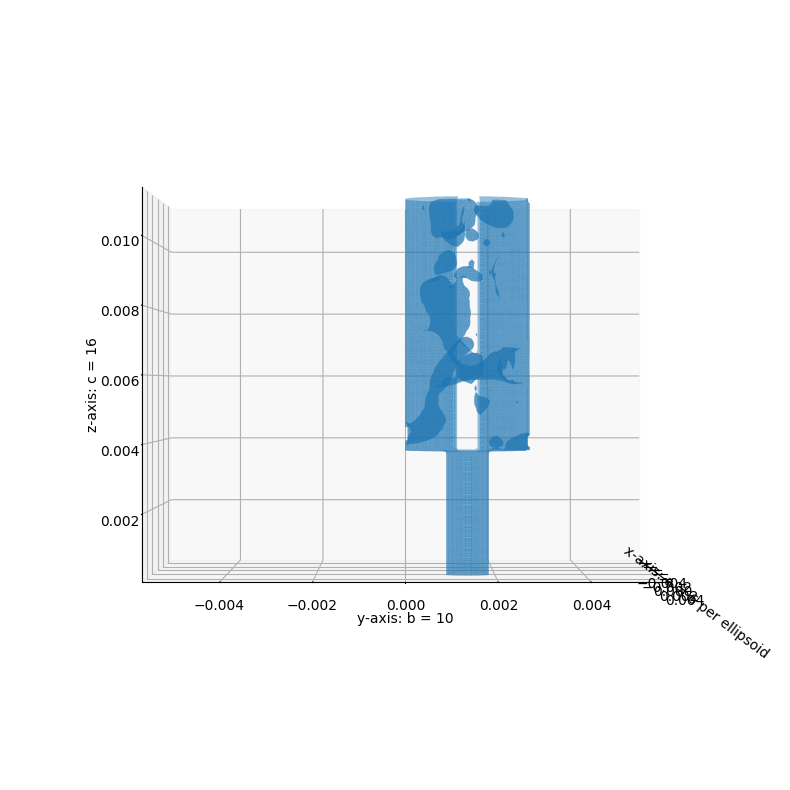

In [33]:
# 等値面を抽出
print(inside_data_F.shape)
verts, faces, normals, values = measure.marching_cubes(inside_data_F, 0.5,spacing=(delta,delta,delta))
verts.shape,faces.shape

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces],alpha=0.5)
# mesh.set_edgecolor('')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev=0, azim=0)  # elevは仰角（上下の角度）、azimは方位角（左右の角度）
# plt.tight_layout()
plt.show()